# **Klasifikasi Multikelas Mutu Citra Biji Kopi Arabika Hijau Berbasis Low Resource Dengan Transfer Learning Dan Machine Learning**

---



Notebook ini disusun untuk kebutuhan skripsi dengan fokus pada klasifikasi multikelas mutu citra
biji kopi arabika hijau menggunakan pendekatan low-resource. Transfer learning hanya digunakan
sebagai ekstraksi fitur, sedangkan klasifikasi dilakukan dengan Support Vector Machine (SVM).

Ekstraksi fitur dilakukan menggunakan tiga arsitektur ringan:
- MobileNetV3 Small
- ShuffleNet V2
- EfficientNetB0

Seluruh model backbone di-freeze (tanpa fine-tuning) agar sesuai dengan skenario low-resource.

# **Step 1 | Configurasi dan Import Library**

In [38]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from google.colab import drive

sns.set_style("white")
pio.renderers.default = "colab"

In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# **Step 2 | Load Dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DATASET_PATH = "/content/drive/MyDrive/USK-Coffee"
TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR = os.path.join(DATASET_PATH, "val")
TEST_DIR = os.path.join(DATASET_PATH, "test")

Mounted at /content/drive


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

dataset = train_ds
CLASS_NAMES = train_ds.class_names

print(f"Found {len(CLASS_NAMES)} classes.")
print("\nCoffe classes:")
print("\n".join(CLASS_NAMES))

Found 4800 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.
Found 4 classes.

Coffe classes:
defect
longberry
peaberry
premium


In [6]:
import os

def count_images_per_class(directory, class_names):
    counts = {}
    total = 0
    for cls in class_names:
        class_dir = os.path.join(directory, cls)
        count = len([
            f for f in os.listdir(class_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])
        counts[cls] = count
        total += count
    return counts, total

print("\nCoffe classes and number of files (train/val/test):")
train_counts, train_total = count_images_per_class(TRAIN_DIR, CLASS_NAMES)
val_counts, val_total = count_images_per_class(VAL_DIR, CLASS_NAMES)
test_counts, test_total = count_images_per_class(TEST_DIR, CLASS_NAMES)

for cls in CLASS_NAMES:
    print(
        f"- {cls:<10} | train: {train_counts[cls]:<4} "
        f"val: {val_counts[cls]:<4} test: {test_counts[cls]:<4}"
    )

print(f"\nTotal train: {train_total}")
print(f"Total val: {val_total}")
print(f"Total test: {test_total}")


Coffe classes and number of files (train/val/test):
- defect     | train: 1200 val: 400  test: 400 
- longberry  | train: 1200 val: 400  test: 400 
- peaberry   | train: 1200 val: 400  test: 400 
- premium    | train: 1200 val: 400  test: 400 

Total train: 4800
Total val: 1600
Total test: 1600


# **Step 3 | Eksplorasi Dataset**

### *3.1 Distribusi Jumlah data per kelas*

In [7]:
# @title
import os
from collections import OrderedDict
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

classes = list(CLASS_NAMES)
train_values = [train_counts[cls] for cls in classes]
val_values = [val_counts[cls] for cls in classes]
test_values = [test_counts[cls] for cls in classes]
total_values = [
    train_counts[cls] + val_counts[cls] + test_counts[cls]
    for cls in classes
]

distribution_df = pd.DataFrame({
    "Kelas": classes,
    "Train": train_values,
    "Val": val_values,
    "Test": test_values
})
distribution_df["Total"] = distribution_df[["Train", "Val", "Test"]].sum(axis=1)
distribution_df = distribution_df.sort_values("Total", ascending=True)

fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'xy'}, {'type': 'xy'}], [{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=(
        "Komposisi Train/Val/Test per Kelas (Stacked)",
        "Perbandingan Jumlah Sampel per Split",
        "Distribusi Total Sampel per Kelas",
        "Proporsi Split Secara Keseluruhan"
    )
)

fig.add_trace(
    go.Bar(
        y=distribution_df["Kelas"],
        x=distribution_df["Train"],
        name="Train",
        orientation='h',
        marker_color='#1A3636'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Bar(
        y=distribution_df["Kelas"],
        x=distribution_df["Val"],
        name="Val",
        orientation='h',
        marker_color='#4CAF50'
    ),
    row=1, col=1
)
fig.add_trace(
    go.Bar(
        y=distribution_df["Kelas"],
        x=distribution_df["Test"],
        name="Test",
        orientation='h',
        marker_color='#8BC34A'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        x=["Train", "Val", "Test"],
        y=[train_total, val_total, test_total],
        marker_color=['#1A3636', '#4CAF50', '#8BC34A'],
        text=[train_total, val_total, test_total],
        textposition="auto",
        textfont=dict(color="white"),
        name="Total per Split"
    ),
    row=1, col=2
)

fig.add_trace(
    go.Pie(
        labels=distribution_df["Kelas"],
        values=distribution_df["Total"],
        hole=0.4,
        textinfo='label+percent',
        marker_colors=px.colors.sequential.Greens
    ),
    row=2, col=1
)

fig.add_trace(
    go.Pie(
        labels=["Train", "Val", "Test"],
        values=[train_total, val_total, test_total],
        hole=0.55,
        textinfo='label+percent',
        marker_colors=['#1A3636', '#4CAF50', '#8BC34A'],
        textfont=dict(color="white")
    ),
    row=2, col=2
)

fig.update_layout(
    title=dict(
        text="Ringkasan Distribusi Dataset per Kelas & Split",
        x=0.5,
        font=dict(size=22)
    ),
    height=850,
    barmode="stack",
    margin=dict(l=260, r=120, t=100, b=60),
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False
)

fig.update_xaxes(title_text="Jumlah Sampel", row=1, col=1)
fig.update_yaxes(
    title_text="Kelas",
    row=1,
    col=1,
    automargin=True,
    ticklabelposition="outside",
    ticklabelstandoff=16
)
fig.update_yaxes(title_text="Jumlah Sampel", row=1, col=2)

fig.show()

### *3.2 Visualisasi contoh citra*

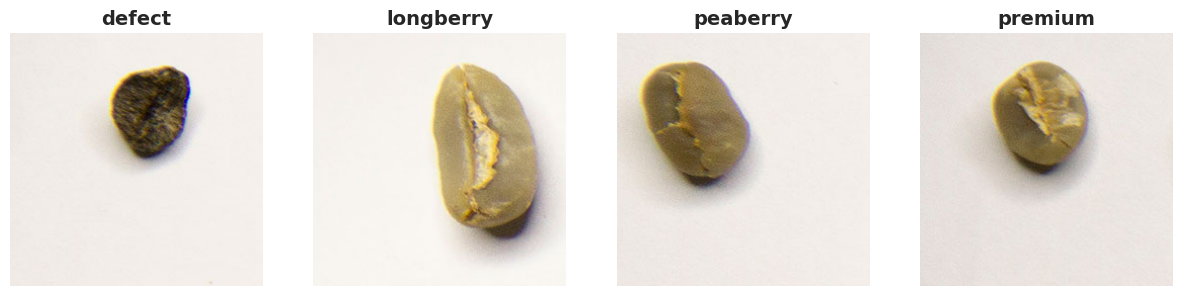

In [8]:
plt.figure(figsize=(15, 6))

for i, cls in enumerate(CLASS_NAMES):
    class_dir = os.path.join(TRAIN_DIR, cls)

    img_name = sorted([
        f for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])[0]

    img_path = os.path.join(class_dir, img_name)
    img = plt.imread(img_path)

    plt.subplot(1, len(CLASS_NAMES), i + 1)
    plt.imshow(img)
    plt.title(cls, fontsize=14, fontweight='bold')
    plt.axis('off')

plt.show()

# **Step 4 | Dataset sudah terbagi (train/val/test)**

In [9]:
print("Coffee classes:")
for cls in CLASS_NAMES:
    print("-", cls)

print("\nTotal classes:", len(CLASS_NAMES))

Coffee classes:
- defect
- longberry
- peaberry
- premium

Total classes: 4


### *4.1 Visualisasi Distribusi per Split*

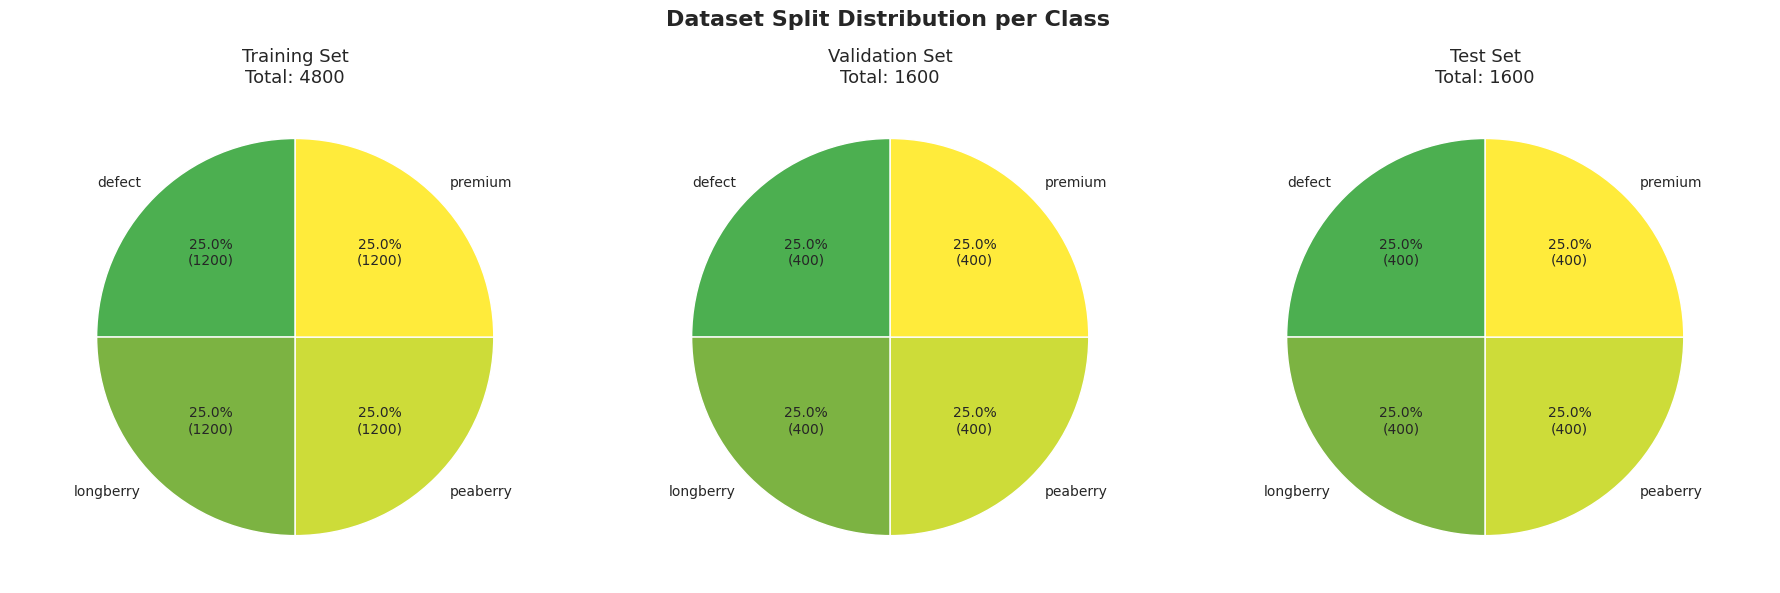

In [10]:
colors = ['#4CAF50', '#7CB342', '#CDDC39', '#FFEB3B',
          '#FFC107', '#FF9800', '#FF5722', '#F44336',
          '#E91E63', '#9C27B0']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
split_data = [
    ("Training Set", train_counts, train_total),
    ("Validation Set", val_counts, val_total),
    ("Test Set", test_counts, test_total)
]

for i, (title, counts_dict, total_count) in enumerate(split_data):
    labels = list(counts_dict.keys())
    counts = list(counts_dict.values())
    axs[i].pie(
        counts,
        labels=labels,
        autopct=lambda p: f"{p:.1f}%\n({int(p*total_count/100)})",
        startangle=90,
        colors=colors[:len(labels)],
        textprops={'fontsize': 10}
    )
    axs[i].set_title(f"{title}\nTotal: {total_count}", fontsize=13)
    axs[i].axis('equal')

plt.suptitle("Dataset Split Distribution per Class", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# **Step 5 | Preprocessing**

In [26]:
# 1) Konversi tipe data ke float32 (tanpa normalisasi manual).
# 2) Normalisasi dilakukan di Step 7 melalui preprocess_input sesuai backbone.

def cast_to_float(image, label):
    return tf.cast(image, tf.float32), label

train_ds = train_ds.map(cast_to_float, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(cast_to_float, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(cast_to_float, num_parallel_calls=AUTOTUNE)

for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)

Images shape: (32, 224, 224, 3)
Labels shape: (32,)


# Step **6 | Data Augmentation**

In [27]:
# Augmentasi hanya diterapkan pada data training untuk menambah variasi.
# Data validasi dan test tidak diaugmentasi agar evaluasi tetap objektif.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
], name="data_augmentation")

def augment_dataset(ds):
    return ds.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_ds_aug = augment_dataset(train_ds).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


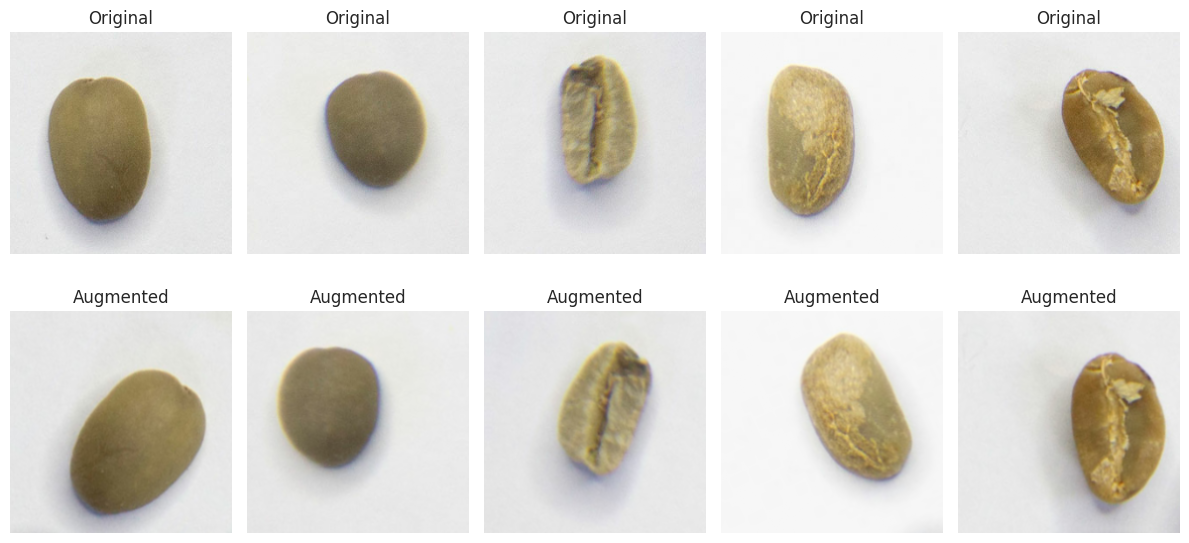

In [29]:
# @title
import matplotlib.pyplot as plt

SHOW_AUG_PREVIEW = True

def normalize_for_display(images):
    images = tf.cast(images, tf.float32)
    images = tf.clip_by_value(images, 0.0, 255.0)
    return (images / 255.0).numpy()

if SHOW_AUG_PREVIEW:
    # Tampilkan before/after dari batch yang sama
    orig_images, _ = next(iter(train_ds))
    aug_images = data_augmentation(orig_images, training=True)

    orig_display = normalize_for_display(orig_images)
    aug_display = normalize_for_display(aug_images)

    plt.figure(figsize=(12, 6))

    for i in range(5):
        # Original
        plt.subplot(2, 5, i + 1)
        plt.imshow(orig_display[i])
        plt.title("Original")
        plt.axis("off")

        # Augmented
        plt.subplot(2, 5, i + 6)
        plt.imshow(aug_display[i])
        plt.title("Augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# **Step 7 | Transfer Learning, dan Fine-Tuning**

In [77]:
# Catatan Cell:
# - Membangun backbone + head.
# - Fine-tuning dilakukan di fungsi fine_tune_backbone.
# Catatan: Jalankan seluruh blok Step 7 ini secara utuh.
# Jangan mengeksekusi baris-baris di dalam fungsi secara terpisah agar tidak
# terjadi IndentationError/NameError.

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

class_names = CLASS_NAMES
NUM_CLASSES = len(class_names)

FINE_TUNE_LAYERS = 20
EPOCHS_HEAD = 5
EPOCHS_FINE = 5

def build_backbone(backbone_name):
    if backbone_name == "mobilenetv3_small":
        base = tf.keras.applications.MobileNetV3Small(
            input_shape=(224, 224, 3),
            include_top=False,
            weights="imagenet"
        )
        preprocess = tf.keras.applications.mobilenet_v3.preprocess_input
    elif backbone_name == "efficientnetb0":
        base = tf.keras.applications.EfficientNetB0(
            input_shape=(224, 224, 3),
            include_top=False,
            weights="imagenet"
        )
        preprocess = tf.keras.applications.efficientnet.preprocess_input
    elif backbone_name == "shufflenetv2":
       import keras_cv
        base = keras_cv.models.ShuffleNetV2Backbone.from_preset(
            "shufflenetv2_1.0_224"
        )
        preprocess = tf.keras.applications.imagenet_utils.preprocess_input
    else:
        raise ValueError(f"Backbone '{backbone_name}' tidak dikenali.")
    return base, preprocess

def _unwrap_backbone_output(output_tensor):
    while isinstance(output_tensor, (tuple, list)):
        output_tensor = output_tensor[0]
    return output_tensor

def build_classifier_model(base, preprocess):
    inputs = layers.Input(shape=(224, 224, 3))
    x = preprocess(inputs)
    x = base(x, training=False)
    x = _unwrap_backbone_output(x)
    if len(x.shape) == 4:
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

def fine_tune_backbone(backbone_name, train_data, val_data):
    # Catatan: seluruh proses fine-tuning ada di dalam fungsi ini.
    # Jangan menjalankan baris seperti "base.trainable = True" secara terpisah.
    base, preprocess = build_backbone(backbone_name)
    model = build_classifier_model(base, preprocess)

    base.trainable = False
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS_HEAD
    )

    base.trainable = True
    fine_tune_at = max(0, len(base.layers) - FINE_TUNE_LAYERS)
    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS_FINE
    )

    return base, preprocess

def build_feature_extractor(backbone_name, base, preprocess):
    inputs = layers.Input(shape=(224, 224, 3))
    x = preprocess(inputs)
    x = base(x, training=False)
    x = _unwrap_backbone_output(x)
    if len(x.shape) == 4:
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.Flatten()(x)
    return tf.keras.Model(inputs, x, name=f"{backbone_name}_extractor")

def extract_features(dataset, feature_extractor):
    features = []
    labels = []
    for images, label_batch in dataset:
        feats = feature_extractor(images, training=False)
        features.append(feats.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(features), np.concatenate(labels)

backbones = [
    "mobilenetv3_small",
    "shufflenetv2",
    "efficientnetb0"
]

# **Step 8 | Ekstraksi Fitur & Klasifikasi SVM**


In [78]:
# Catatan Cell:
# - Ekstraksi fitur dari backbone terlatih.
# - Klasifikasi menggunakan SVM (StandardScaler + SVC).

results = []
svm_models = {}
feature_extractors = {}

for backbone_name in backbones:
    print(f"\n=== Fine-tuning backbone: {backbone_name} ===")
    tuned_base, preprocess = fine_tune_backbone(
        backbone_name,
        train_ds_aug,
        val_ds
    )
    extractor = build_feature_extractor(backbone_name, tuned_base, preprocess)
    feature_extractors[backbone_name] = extractor

    X_train, y_train = extract_features(train_ds_aug, extractor)
    X_test, y_test = extract_features(test_ds, extractor)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(
            kernel="rbf",
            C=10,
            gamma="scale",
            decision_function_shape="ovr"
        ))
    ])

    svm_clf.fit(X_train, y_train)
    svm_models[backbone_name] = svm_clf

    y_pred = svm_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Backbone": backbone_name,
        "Test Accuracy": acc
    })

    print(f"Test Accuracy ({backbone_name} + SVM): {acc:.4f}")
    print(classification_report(
        y_test,
        y_pred,
        target_names=class_names
    ))


=== Fine-tuning backbone: mobilenetv3_small ===
Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 2485s 17s/step - accuracy: 0.4344 - loss: 1.3443 - val_accuracy: 0.7312 - val_loss: 0.7564
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 71s 468ms/step - accuracy: 0.6854 - loss: 0.8181 - val_accuracy: 0.7825 - val_loss: 0.6342
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.7483 - loss: 0.6883 - val_accuracy: 0.7906 - val_loss: 0.6031
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 72s 469ms/step - accuracy: 0.7615 - loss: 0.6531 - val_accuracy: 0.8000 - val_loss: 0.5629
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 76s 500ms/step - accuracy: 0.7733 - loss: 0.6135 - val_accuracy: 0.8081 - val_loss: 0.5460
Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 89s 492ms/step - accuracy: 0.6242 - loss: 0.9616 - val_accuracy: 0.7406 - val_loss: 0.6994
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 77s 509ms/step - accuracy: 0.7367 - loss: 0.6872 - val_accuracy: 0.7225 - val_loss: 0.7453
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 73

NameError: name 'keras_cv' is not defined

# **Step 9 | Evaluasi Model dan Visualisasi**





In [ ]:
# Catatan Cell:
# - Menampilkan hasil evaluasi per backbone.
# - Visualisasi confusion matrix dan perbandingan akurasi.

results_df = pd.DataFrame(results).sort_values(
    by="Test Accuracy",
    ascending=False
)
results_df

best_backbone = results_df.iloc[0]["Backbone"]
print(f"Best Backbone (SVM): {best_backbone}")

best_extractor = feature_extractors[best_backbone]
best_svm = svm_models[best_backbone]

X_test_best, y_test_best = extract_features(test_ds, best_extractor)
y_pred_best = best_svm.predict(X_test_best)

cm_best = confusion_matrix(y_test_best, y_pred_best)

disp_best = ConfusionMatrixDisplay(
    confusion_matrix=cm_best,
    display_labels=class_names
)

disp_best.plot(cmap="Greens", xticks_rotation=45)
plt.title(f"Confusion Matrix – {best_backbone} + SVM")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(
    results_df["Backbone"],
    results_df["Test Accuracy"],
    color=["#1A3636", "#4CAF50", "#8BC34A"]
)
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Comparison of Backbone Feature Extractors + SVM")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

,Model,Test Accuracy
0,CNN Custom,0.727778
1,MobileNetV2,0.977778


# **Step 10 | Simpan Model**

In [ ]:
# Catatan Cell:
# - Simpan model SVM terbaik dan feature extractor.

import joblib

joblib.dump(best_svm, f"svm_best_{best_backbone}.joblib")
best_extractor.save(f"feature_extractor_{best_backbone}.h5")

print("Models saved successfully:")
print(f"- svm_best_{best_backbone}.joblib")
print(f"- feature_extractor_{best_backbone}.h5")
